In [70]:
import json
import pandas as pd
import matplotlib.pyplot as plt

In [71]:
IODEPTH_RESULT = './data/iobandwidth_results.json'
result_jsons = {}
with open(IODEPTH_RESULT, 'r') as f:
    result_jsons = json.load(f)


In [72]:
!lscpu

zsh:1: command not found: lscpu


In [73]:
!uname -a

Darwin Muteebs-MacBook-Air.local 23.1.0 Darwin Kernel Version 23.1.0: Mon Oct  9 21:28:31 PDT 2023; root:xnu-10002.41.9~6/RELEASE_ARM64_T8112 arm64


In [74]:
!nproc

zsh:1: command not found: nproc


In [75]:
df = pd.json_normalize(result_jsons)
io_bandwidth = df[df['experiment_name'] == "CoresVsIOBandwidth"].copy()


In [76]:
def read_iops(jobs):
     return jobs[0]['read']['iops']

def write_iops(jobs):
    # We have group reporting turned on. So read of the first job
     return jobs[0]['write']['iops']

def median_latency(jobs):
    # Some metrics are easier to etract via a json, fow now we'll brute force it
    # jobs_pd = pd.json_normalize(jobs, max_level=0)
    median_lat = jobs[0]['read']['lat_ns']['percentile']['50.000000']
    return median_lat

def num_jobs(jobs):
    return jobs[0]['job options']['numjobs']

def test_transform(x):
    return 10

def summarize_df(df):
    df['readiops'] = df['jobs'].map(read_iops)
    df['writeiops'] = df['jobs'].map(write_iops)
    df['median_lat'] = df['jobs'].map(median_latency)
    df['numjobs'] = df['jobs'].map(num_jobs)
    df['iodepth'] = df['global options.iodepth'].astype(int)

summarize_df(io_bandwidth)

<Axes: xlabel='readiops'>

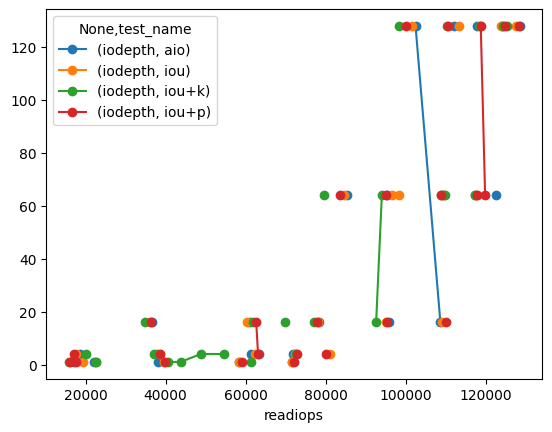

In [77]:
io_bandwidth.pivot(index="readiops", columns=["test_name"], values=["iodepth", "numjobs"]).plot(marker='o')

<Axes: xlabel='readiops'>

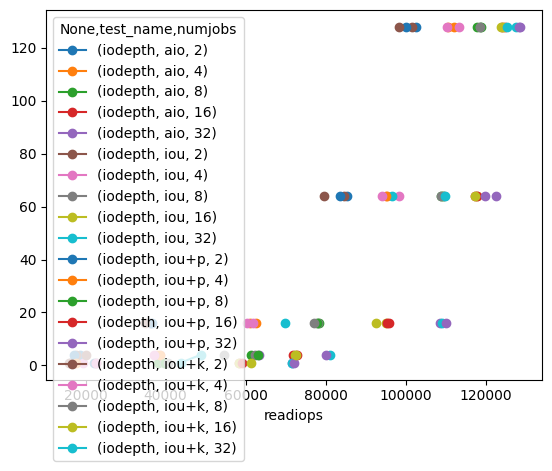

In [78]:
io_bandwidth.pivot(index="readiops", columns=["test_name", "numjobs"], values=["iodepth"]).plot(marker='o')

<Axes: xlabel='numjobs'>

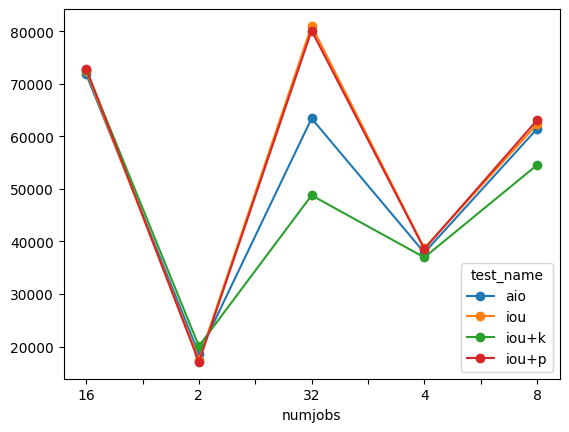

In [79]:
io_bandwidth_iodepth_4 = io_bandwidth.loc[io_bandwidth['iodepth'] == 4]
io_bandwidth_iodepth_4.sort_values(by='numjobs')
io_bandwidth_iodepth_4.pivot(index="numjobs", columns="test_name", values="readiops").plot(marker='o')